# QMSA witout encoding the dataset

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
import numpy as np
import math
import random

### STEP 1: Prepare input state

In [2]:
# Dataset
PG_i = [int(random.random()*100) for _ in range(2**4)]

# Define the number of qubits
num_qubits = math.ceil(math.log2(len(PG_i)))

# Create the data and ancilla registers
data = QuantumRegister(num_qubits, 'data')
cr = ClassicalRegister(num_qubits, 'classical')

# Create a quantum circuit 
qc = QuantumCircuit(data, cr)

# Create a uniform superposition
qc.h(range(num_qubits))

### STEP 2 : Sample pivot theta

In [3]:
theta_index = random.randint(0,len(PG_i)-1) 
theta =  PG_i[theta_index]

### STEP 3 : Define Grover Operator

In [4]:
def oracle(num_qubits, PG_i, theta):
    data = QuantumRegister(num_qubits, 'data')
    qc = QuantumCircuit(data, name='Oracle')

    oracle = np.identity(len(PG_i))

    for i in range(len(PG_i)):
        if PG_i[i] > theta:
            oracle[i][i] = -1

    qc.unitary(oracle, data)
    
    return qc

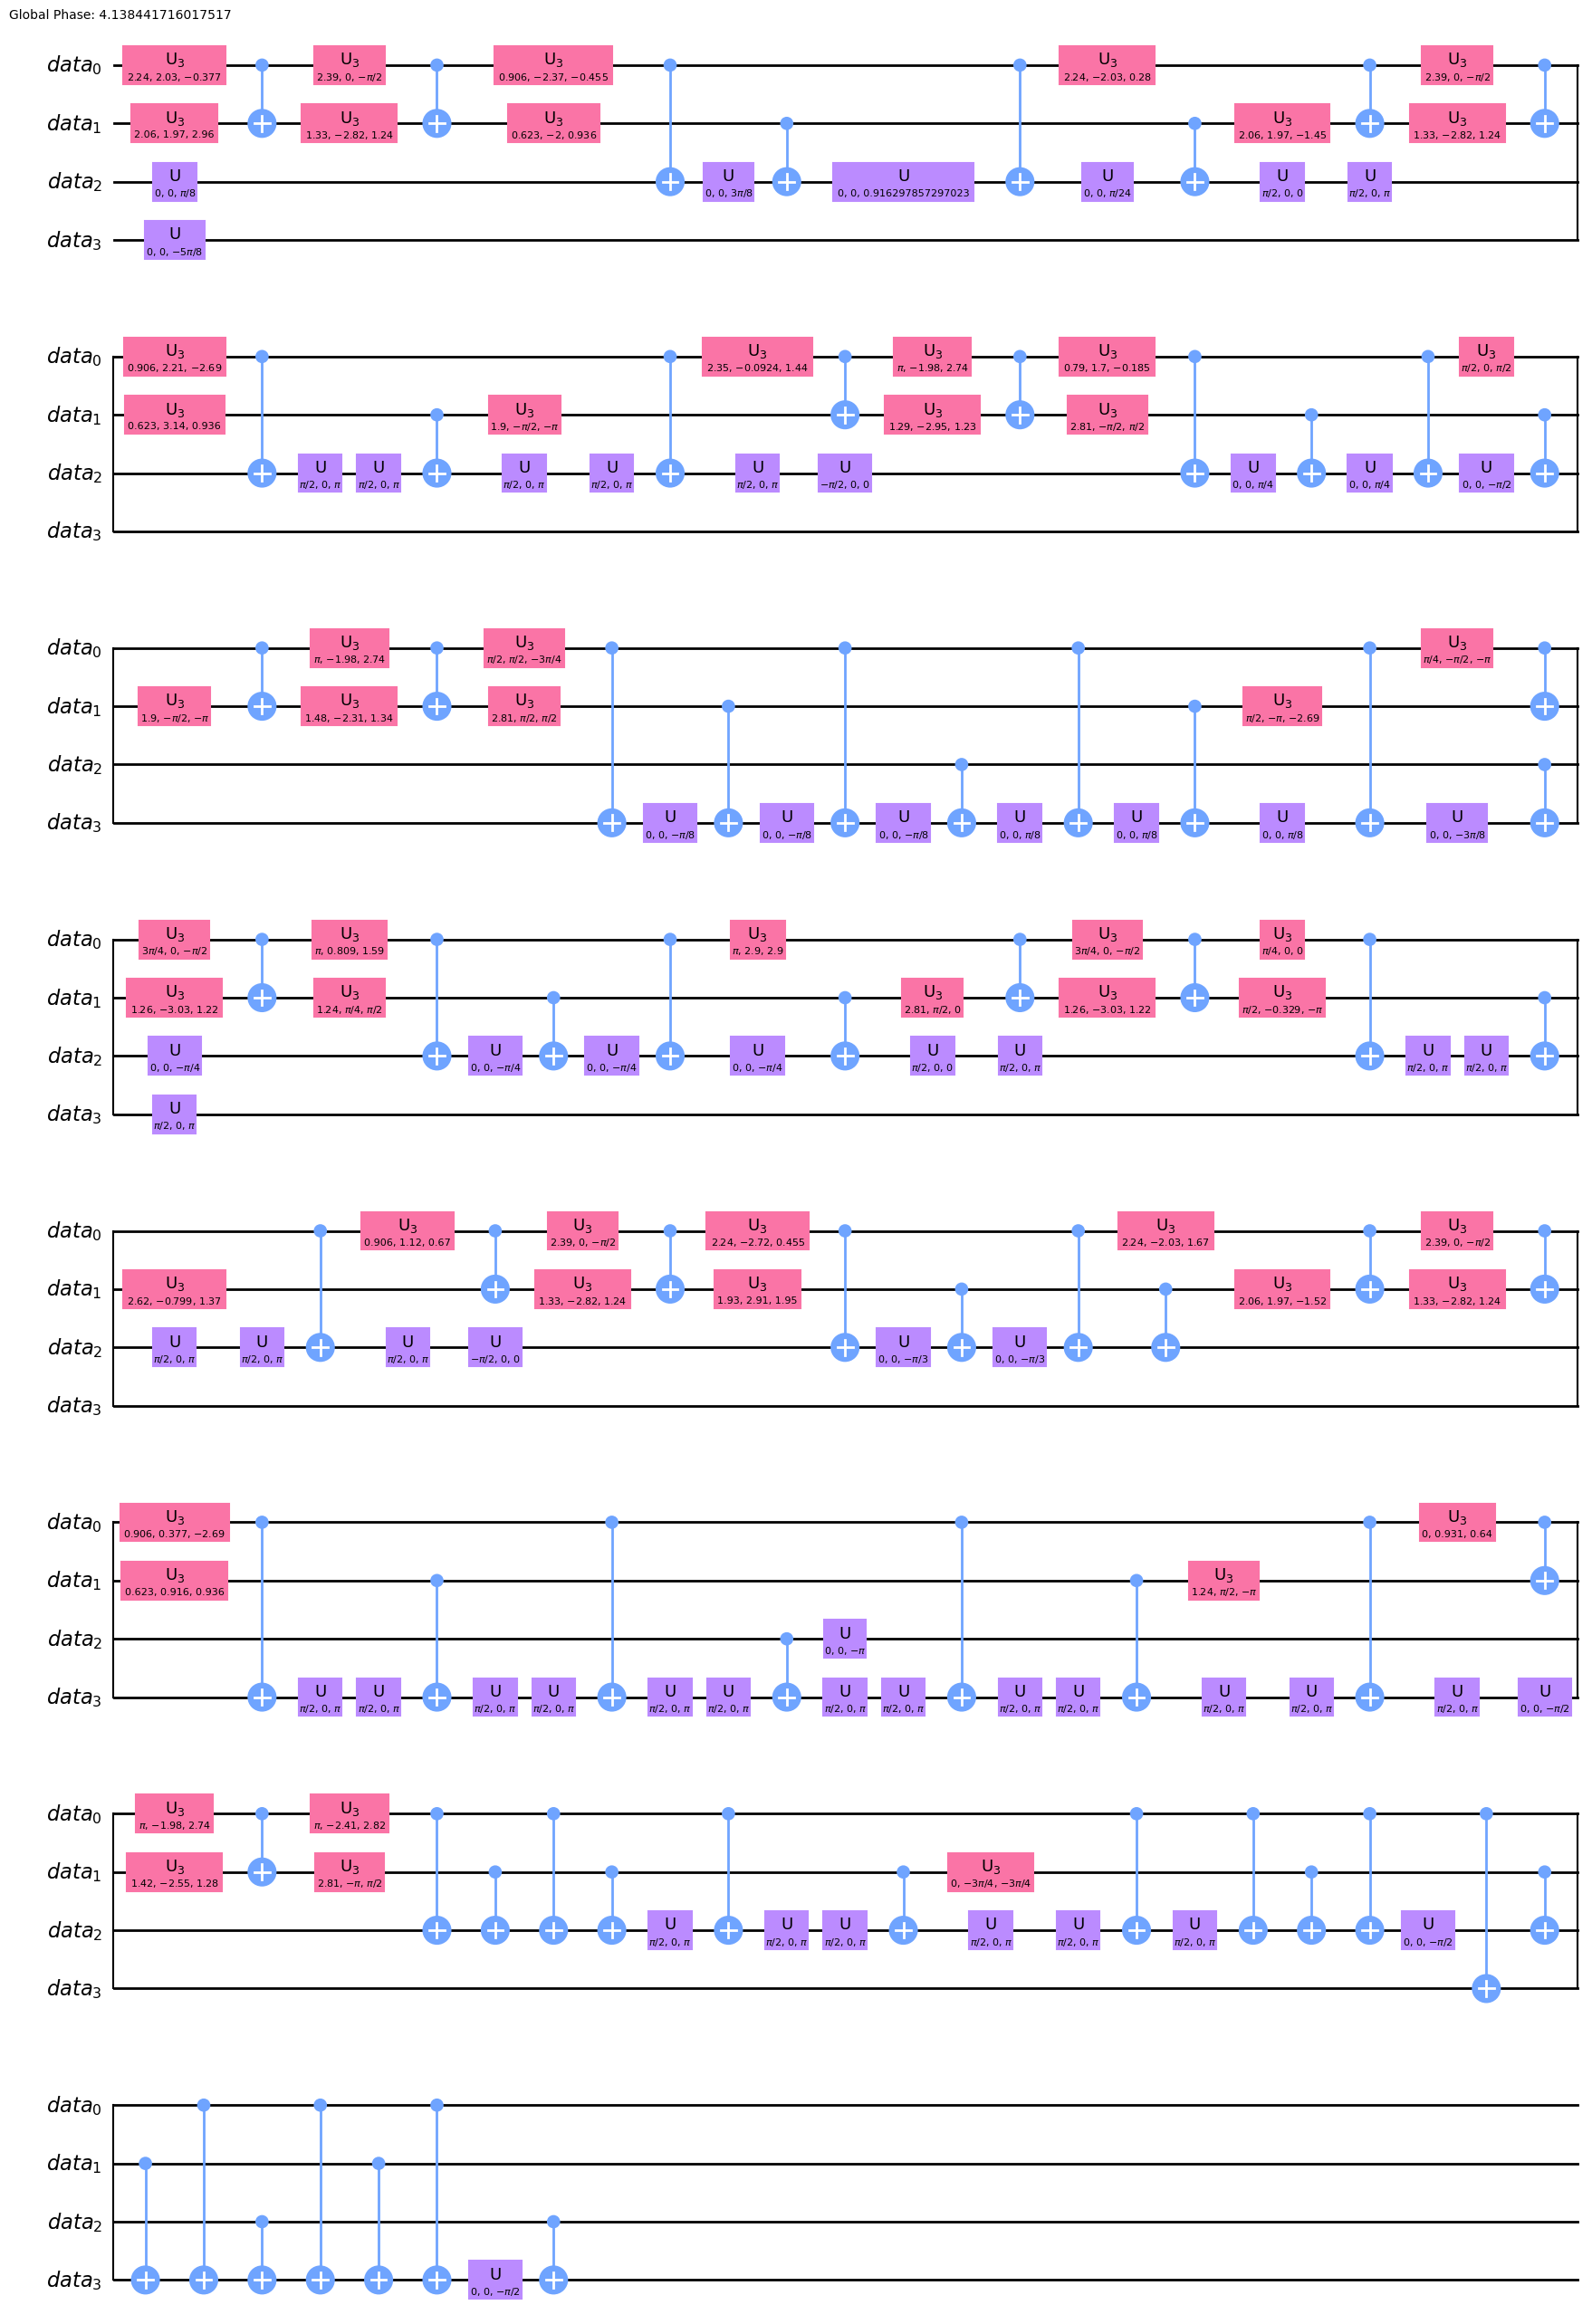

In [5]:
oracle(num_qubits, PG_i, theta).decompose().decompose().draw(output='mpl')

In [6]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits, name='Diffuser')
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
        
    return qc

### STEP 4 : Grover iterations

In [7]:
def grover_iteration(num_iterations, qc, num_qubits, theta, data, cr):
    
    for _ in range(0, num_iterations+1):
        qc.append(oracle(num_qubits, PG_i, theta), [*[i for i in range(num_qubits)]])
        qc.append(diffuser(num_qubits), [*[i for i in range(num_qubits)]])
    
    qc.measure(data, cr)
    backend = Aer.get_backend("qasm_simulator")
    job = execute(qc, backend, shots=1024)
    #job = execute(qc, backend, shots=1)
    
    new_theta_index = int(sorted(job.result().get_counts().items(), key=lambda x: x[1])[-1][0], 2)
    #new_theta_index = int(list(job.result().get_counts().keys())[0],2)
    
    qc.barrier()
    # Create a uniform superposition
    qc.h(range(num_qubits))
    
    return new_theta_index

### STEP 5 : QESA

In [8]:
def QESA(max_iteration, PG_i, qc, num_qubits, theta, data, cr):

    m = 1
    alpha = 6/5
    
    while True:
        num_iterations = random.randint(0, int(m)) 
        print('num_iterations :',num_iterations)
        new_theta_index = grover_iteration(num_iterations, qc, num_qubits, theta, data, cr)
       
        if PG_i[new_theta_index] < theta:
            m = max(alpha*m, math.sqrt(len(PG_i)))
            print('not found...')
        else:
            print('Found!')
            break
        
    return new_theta_index

### STEP 5 : Result

In [9]:
#max_iteration = int(22.5 * math.sqrt(len(PG_i)) + 1.4 * math.log2(len(PG_i)))
max_iteration = int(math.sqrt(len(PG_i)))
print("max_iteration : ",max_iteration)

for _ in range(0, max_iteration):
    new_theta_index = QESA(max_iteration, PG_i, qc, num_qubits, theta, data, cr)
    print('new_theta :', PG_i[new_theta_index])

max_iteration :  4
num_iterations : 1
not found...
num_iterations : 1
Found!
new_theta : 23
num_iterations : 1
not found...
num_iterations : 0
Found!
new_theta : 55
num_iterations : 0
Found!
new_theta : 15
num_iterations : 0
Found!
new_theta : 77


In [10]:
print("QUANTUM MAX : ", PG_i[new_theta_index])

PG_i.sort()
classi_best_suggestion = PG_i[-1]

print("CLASSICAL MAX : ", classi_best_suggestion)

QUANTUM MAX :  77
CLASSICAL MAX :  77


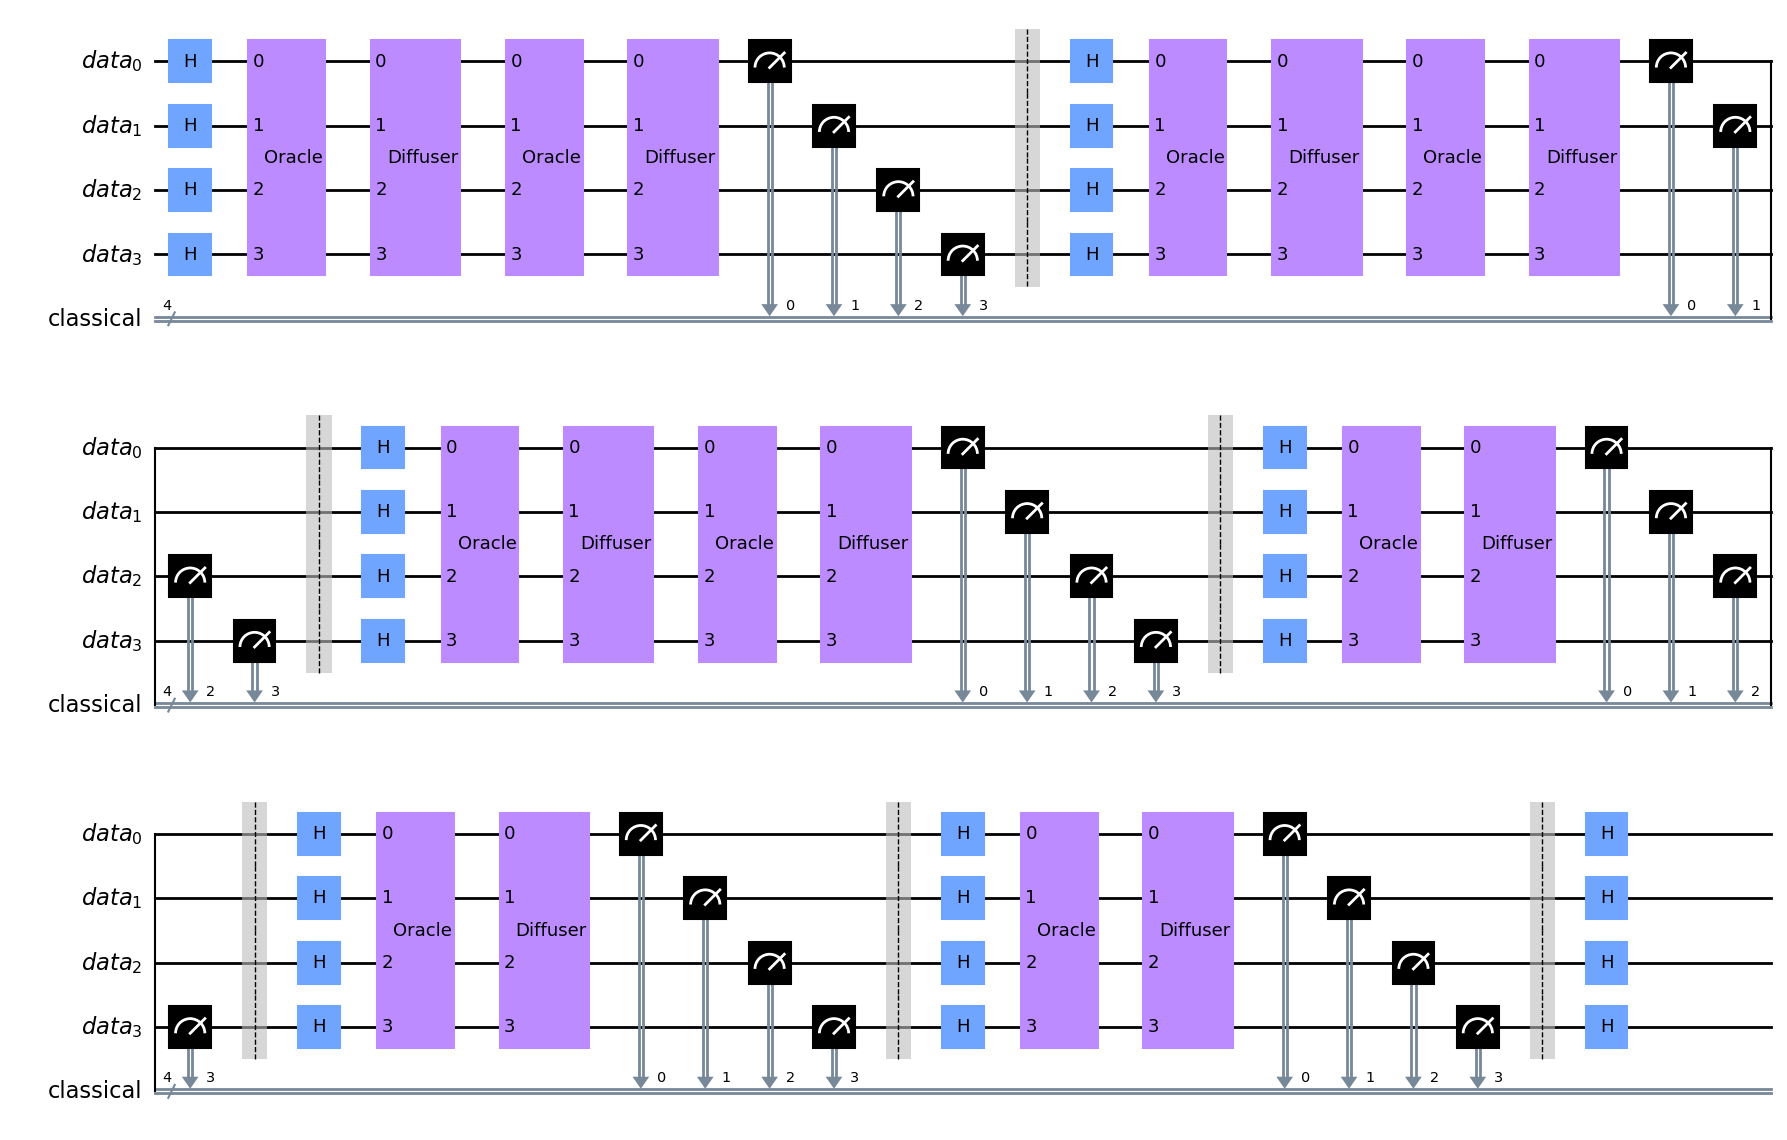

In [11]:
qc.draw(output='mpl')